In [3]:
# ===================================
# !!! SET UP PATH AND MERGE FILES !!!
# ===================================

import csv
import numpy as np
import pandas as pd
import os

folder = 'tesi_bkg_1e6_nominal_1dof_fullE_part1'
path = '/home/ambra/Desktop/cluster-morgana/archive_tests/' + \
        folder + '/run0406_bkg/run0406_ID000126/csv/'

Nchunk = 20 

texp = [1, 5, 10, 100]
sigma = [5]
chunk = [i+1 for i in range(Nchunk)]

#csvName[texp][chunk]
csvName = [[]*i for i in range(len(texp))]
for i in range(len(chunk)) :  
    for j in range(len(texp)) :
        csvName[j].append('bkg_%ds_chunk%02d.csv' % (texp[j], chunk[i]))
        
# merge files ---!
csvMerged= []
for j in range(len(texp)) :
    csvMerged.append('bkg_%ds.csv' % texp[j])

    fout = open(path+csvMerged[j],'w+')
    # first file ---!
    for line in open(path+csvName[j][0]):
        fout.write(line)
    # remaining files ---!    
    for i in range(len(chunk)-1):
        f = open(path+csvName[j][i+1])
        next(f) # skip the header ---!
        for line in f:
             fout.write(line)
        f.close() 
    fout.close()
    
print(csvMerged)




['bkg_1s.csv', 'bkg_5s.csv', 'bkg_10s.csv', 'bkg_100s.csv']


In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from scipy.stats import chi2

# DATA ---!
png_path = '/home/ambra/Desktop/cluster-morgana/archive_tests/' + folder + '/png/'
if not os.path.isdir(png_path):
    os.mkdir(png_path)
filename = csvMerged[3]

# load DataFrame and column names ---!
df = pd.read_csv(path+filename)
cols = list(df.columns)
trials = len(df[cols[0]])
print('verify trials = ', trials)
# drop duplicates ---! 
df.sort_values(cols[0], inplace = True) 
# dropping ALL duplicte values 
df.drop_duplicates(subset=cols[0], keep='last', inplace=True) 
trials = len(df[cols[0]])
print('verify trials = ', trials)
# drop NaN ---!
#df = df.dropna()

# set arrays ---!
trial = np.array(df[cols[0]])
tsv = np.array(df[cols[2]])

tsv.sort()

tsv2 = []
for i in range(len(tsv)):
    tsv2.append(tsv[i]) if tsv[i] >=0.5 else None

wbin = 1.
nbin = int(tsv.max()/wbin)
print('ts bin:', nbin)

verify trials =  623462
verify trials =  623462
ts bin: 21


2000000 2000000


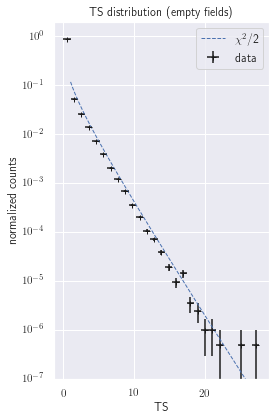

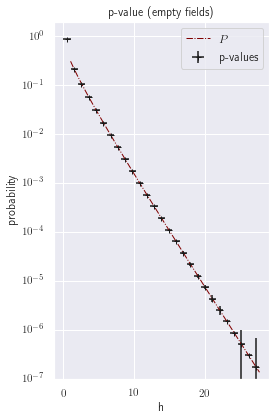

In [3]:
from module_statistics import *

ts = []
for i in range(trials) :
    if tsv[i] < 0.0 :
        ts.append(0.0)
    else :
        ts.append(tsv[i])
        
print(len(tsv), len(ts))

fig, ax = ts_wilks(ts, trials, nbin=nbin, width=wbin, 
                   filename=png_path + filename.replace('.csv', '_wilks.png'), ylim=(1e-7, 2e0))
fig.figure

fig, ax = p_values(ts, trials, nbin=nbin, width=wbin, 
                   filename=png_path + filename.replace('.csv', '_pvalues.png'), ylim=(1e-7, 2e0))
fig.figure



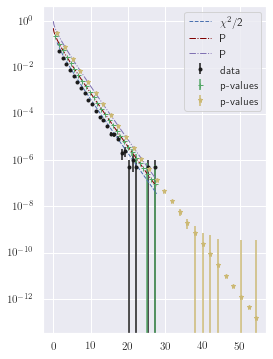

In [7]:
fig1 = plt.figure(figsize=(4,6))
ax = plt.subplot(111, yscale='log')

ts2 = []
for i in range(trials) :
    if ts[i] >= 1.0 :
        ts2.append(ts[i])

# TS DIST BLACK ---!
h, edges = np.histogram(ts2, bins=int(nbin), density=False, range=(1., max(ts)))
h_norm = h / trials
err_norm = np.sqrt(h) / trials
cbin = (edges[1:] + edges[:-1])/2

plt.errorbar(cbin, h_norm, fmt='ko', yerr=err_norm, markersize=3, label='data')
plt.plot(ts2, stats.chi2.pdf(ts2, df=1)/2, lw=1, ls='--', label='$\\chi^2$/2')

# P-VALUE DIST GREEN ---! 1)
h, edges = np.histogram(ts, bins=int(nbin), density=False, range=(0., max(ts)))
h_norm = h / trials
err_norm = np.sqrt(h) / trials
cbin = (edges[1:] + edges[:-1])/2
h_norm = (1-stats.chi2.cdf(cbin, df=1))/2

plt.errorbar(cbin, h_norm, yerr=err_norm, fmt='g+', markersize=5, label='p-values')
plt.plot(ts, (1-stats.chi2.cdf(ts, df=1))/2, lw=1, ls='-.', c='maroon', label='P')


# P-VALUE DIST YELLOW ---! 2)
h, edges = np.histogram(ts, bins=int(nbin), density=True, range=(0., max(ts)))
h_norm = h / trials
err_norm = np.sqrt(h) / trials
cbin = (edges[1:] + edges[:-1])
h_norm = (1-stats.chi2.cdf(cbin, df=1))

plt.errorbar(cbin, h_norm, yerr=err_norm, fmt='y*', markersize=5, label='p-values')
plt.plot(ts, (1-stats.chi2.cdf(ts, df=1)), lw=1, ls='-.', c='m', label='P')


plt.legend(loc=0)

plt.show()


2000000


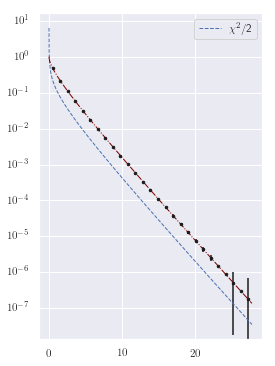

In [4]:
fig1 = plt.figure(figsize=(4,6))
ax = plt.subplot(111, yscale='log')

pvalues = (1-stats.chi2.cdf(ts, df=1))
print(len(pvalues))

h, edges = np.histogram(ts, bins=int(nbin), density=False, range=(0., max(ts)))
h_norm = h / trials
err_norm = np.sqrt(h) / trials
cbin = (edges[1:] + edges[:-1])/2
h_norm = (1-stats.chi2.cdf(cbin, df=1))

#plt.errorbar(ts, pvalues, fmt='r.', markersize=3)
plt.errorbar(cbin, h_norm, yerr=err_norm, fmt='k.', markersize=5)
plt.plot(ts, stats.chi2.pdf(ts, df=1)/2, lw=1, ls='--', label='$\\chi^2$/2')
plt.plot(ts, (1-stats.chi2.cdf(ts, df=1)), lw=1, ls='-.', c='maroon')

plt.legend()

fig.figure